In [1]:
"""
The purpose of this Jupyter notebook is to determine whether Z-scoring
alleviates plate-to-plate variation or not. To this end, a
dimensionality reduction is performed by means of UMAP for both cases,
i.e. raw values and Z-scored values. Subsequently, it is evaluated by
eye whether the potential clustering by plate is alleviated or not. As
input to the UMAP algorithm, vectors are used containing the raw and
Z-scored values of the measurements, respectively (intensity values and
cell count).
"""

'\nThe purpose of this Jupyter notebook is to determine whether Z-scoring\nalleviates plate-to-plate variation or not. To this end, a\ndimensionality reduction is performed by means of UMAP for both cases,\ni.e. raw values and Z-scored values. Subsequently, it is evaluated by\neye whether the potential clustering by plate is alleviated or not. As\ninput to the UMAP algorithm, vectors are used containing the raw and\nZ-scored values of the measurements, respectively (intensity values and\ncell count).\n'

In [1]:
import os

import numpy as np
import pandas as pd
import umap
from matplotlib import pyplot as plt

In [2]:
# First, load the humongous CSV file into a Pandas DataFrame
path_to_screen_csv = (
    "/Users/jacobanter/Documents/Code/VACV_screen/VacciniaReport_"
    "20170223-0958_ZScored_conc_and_NaN_adjusted.csv"
)

entire_screen_df = pd.read_csv(
    path_to_screen_csv,
    sep="\t"
)

/var/folders/j1/64kbg_f11z97kx1dw__420vh0000gn/T/ipykernel_1054/2353677796.py:7: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  entire_screen_df = pd.read_csv(


In [3]:
# Images are only available for the Dharmacon pooled (DP) subset of the
# screen
# Thus, the corresponding subset is extracted and the controls are
# determined
# There are two whole genome subsets (DP-G1 and DP-G2); these are
# technical replicates/duplicates
# Hence, it theoretically does not matter which of the two subsets is
# chosen for the identification of the controls
# However, it is investigated whether the two duplicates encompass the
# same controls
dp_g1_df = entire_screen_df[
    entire_screen_df["Experiment"] == "VACCINIA-DP-G1"
]
dp_g2_df = entire_screen_df[
    entire_screen_df["Experiment"] == "VACCINIA-DP-G2"
]

In [4]:
# Apart from that, note that there is a difference between so-called
# screening plates (PLATE_TYPE==ScreeningPlate) and chequerboard plates
# (PLATE_TYPE==CheckerBoard)
# The former contain both controls and gene interrogations, whereas the
# latter exclusively contain controls
# Only the controls of screening plates are to be considered
control_names_dp_g1 = dp_g1_df.loc[
    (dp_g1_df["WellType"] == "CONTROL")
    &
    (dp_g1_df["PLATE_TYPE"] == "ScreeningPlate"),
    "Name"
].unique()

print(control_names_dp_g1)

control_names_dp_g2 = dp_g2_df.loc[
    (dp_g2_df["WellType"] == "CONTROL")
    &
    (dp_g2_df["PLATE_TYPE"] == "ScreeningPlate"),
    "Name"
].unique()

print(control_names_dp_g2)

['ATP6V1A' 'SCRAMBLED' 'MOCK' 'PSMC3' 'KIF11' 'PSMA6' 'TSG101'
 'GFP Duplex III' 'RAC1' 'ARPC3' 'CDC42' 'PAK1' 'UNKNOWN']
['ATP6V1A' 'SCRAMBLED' 'MOCK' 'PSMC3' 'KIF11' 'PSMA6' 'TSG101'
 'GFP Duplex III' 'RAC1' 'ARPC3' 'CDC42' 'PAK1' 'UNKNOWN']


In [5]:
assert len(control_names_dp_g1) == len(control_names_dp_g2), (
    "The screening plates of the two duplicates do not contain the "
    "same amount of controls!"
)

In [6]:
# Determine the number of unique plates in the Dharmacon pooled subset
# Note that filtering has to be applied regarding the well type as well
# as the plate type
n_plates_dp_g1 = len(
    dp_g1_df.loc[
        (dp_g1_df["WellType"] == "CONTROL")
        &
        (dp_g1_df["PLATE_TYPE"] == "ScreeningPlate"),
        "Barcode"
    ].unique()
)

# The number of plates should be the same, irrespective of the well type
# considered
n_plates_dp_g1_all_wells = len(
    dp_g1_df.loc[
        dp_g1_df["PLATE_TYPE"] == "ScreeningPlate",
        "Barcode"
    ].unique()
)

assert n_plates_dp_g1 == n_plates_dp_g1_all_wells, (
    "For DP-G1, the number of plates depends on the well type "
    "considered!"
)

n_plates_dp_g2 = len(
    dp_g2_df.loc[
        (dp_g2_df["WellType"] == "CONTROL")
        &
        (dp_g2_df["PLATE_TYPE"] == "ScreeningPlate"),
        "Barcode"
    ].unique()
)

n_plates_dp_g2_all_wells = len(
    dp_g2_df.loc[
        dp_g2_df["PLATE_TYPE"] == "ScreeningPlate",
        "Barcode"
    ].unique()
)

assert n_plates_dp_g2 == n_plates_dp_g2_all_wells, (
    "For DP-G2, the number of plates depends on the well type "
    "considered!"
)

print(
    f"DP-G1 comprises {n_plates_dp_g1} plates, while DP-G2 comprises "
    f"{n_plates_dp_g2} plates."
)

sum_n_plates = n_plates_dp_g1 + n_plates_dp_g2

print(
    "Number of different plates in the Dharmacon pooled subset: "
    f"{sum_n_plates}"
)

DP-G1 comprises 57 plates, while DP-G2 comprises 57 plates.
Number of different plates in the Dharmacon pooled subset: 114


In [7]:
# As it turns out, there are 114 different plates in total
# However, this is way too many to visualize
# Therefore, visualization starts with a small number of plates and
# successively adds plates until the image becomes too crowded

# It emerges that each control is present four times on each plate
# For each control well, a dimensionality reduction to two dimensions is
# performed by means of UMAP, following which they are visualized
# The input vectors for dimensionality reduction comprise the following
# features:
# cell count (eCount_oCells)
# early nucleus intensity (dIntensity_cPathogen_eMean_oNuclei)
# early perinucleus intensity (dIntensity_cPathogen_eMean_oPeriNuclei)
# early cell intensity (dIntensity_cPathogen_eMean_oCells)
# late nucleus intensity (dIntensity_cLatePathogen_eMean_oNuclei)
# late perinucleus intensity (dIntensity_cLatePathogen_eMean_oPeriNuclei)
# late cell intensity (dIntensity_cLatePathogen_eMean_oCells)

# Perinuclear and Voronoi measurements are kind of redundant as both
# perform tesselation
# For this reason, the Voronoi feature is omitted in favor of the
# perinucleus feature

# The UMAP algorithm has to be trained on data
# Thus, despite visualizing only a limited number of plates, training is
# performed on all plates
# Apart from that, training is done in two different manners: The first
# manner consists of per-control dimensionality reduction, i.e.
# dimensionality reduction is performed for each control separately
# The second manner involves pooled dimensionality reduction, i.e. all
# controls are jointly reduced

### Dimensionality reduction of raw values

In [8]:
# Remove the "UNKNOWN" entry from the control names lists
control_names_dp_g1 = control_names_dp_g1.tolist()
control_names_dp_g1.remove("UNKNOWN")
control_names_dp_g2 = control_names_dp_g2.tolist()
control_names_dp_g2.remove("UNKNOWN")

assert (
    ("UNKNOWN" not in control_names_dp_g1)
    and
    ("UNKNOWN" not in control_names_dp_g2)
), "Removal of the 'UNKNOWN' entries was not successful!"

In [9]:
# Extract the Dharmacon pooled subset from the entire screen without
# distinction between the two replicates
# Also make sure to include all well types, not only control wells
dp_screening_plates_df = entire_screen_df[
    ((entire_screen_df["Experiment"] == "VACCINIA-DP-G1")
    |
    (entire_screen_df["Experiment"] == "VACCINIA-DP-G2"))
    &
    (entire_screen_df["PLATE_TYPE"] == "ScreeningPlate")
]

In [10]:
# Perform a couple of sanity checks to verify that slicing has been done
# correctly
n_plates_dp = len(dp_screening_plates_df["Barcode"].unique())

assert n_plates_dp == sum_n_plates, (
    "Something went wrong while extracting the subset!"
)

In [11]:
# Verify that the order in which the unique barcodes appear is the same
# for all controls
# Conveniently enough, Pandas's `.unique()` method does not sort, but
# lists the unique values in order of appearance
unique_plate_barcodes = dp_screening_plates_df["Barcode"].unique()

for control in control_names_dp_g1:
    control_barcodes = dp_screening_plates_df.loc[
        dp_screening_plates_df["Name"] == control,
        "Barcode"
    ].unique()
    
    assert all(unique_plate_barcodes == control_barcodes), (
        f"For control {control}, the order of the plate barcodes "
        "differs from that of the other controls."
    )

# For each control, verify that each plate/barcode occurs four times
# Checking that identical plates/barcodes form contiguous blocks, i.e.
# appear consecutively within the column is not necessary as plate
# selection can conveniently be accomplished via Boolean indexing
n_occurrences_list = []

for control in control_names_dp_g1:
    control_barcode_list = dp_screening_plates_df.loc[
        dp_screening_plates_df["Name"] == control,
        "Barcode"
    ].tolist()
    for barcode in unique_plate_barcodes:
        n_occurrences = control_barcode_list.count(barcode)
        n_occurrences_list.append(n_occurrences)
        if n_occurrences != 4:
            print(
                f"In control {control}, barcode {barcode} does not occur "
                f"four times, but {n_occurrences} times!"
            )

print(
    "\nControls occur the following numbers of times: "
    f"{np.unique(n_occurrences_list)}"
)

In control ATP6V1A, barcode DZ15-2M does not occur four times, but 5 times!
In control ATP6V1A, barcode DZ15-2N does not occur four times, but 5 times!
In control SCRAMBLED, barcode DZ01-2M does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ01-2N does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ02-2M does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ02-2N does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ03-2M does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ03-2N does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ04-2M does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ04-2N does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ05-2M does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ05-2N does not occur four times, but 12 times!
In control SCRAMBLED, barcode DZ06-2M does not occur four 

#### Per-control reduction

In [17]:
# Iterate over the list of control names, extract the corresponding
# subset from the DataFrame and perform the dimensionality reduction
reduced_embs_per_control = []

for control in control_names_dp_g1:
    control_raw_subset = dp_screening_plates_df.loc[
        dp_screening_plates_df["Name"] == control,
        [
            "eCount_oCells",
            "dIntensity_cPathogen_eMean_oNuclei",
            "dIntensity_cPathogen_eMean_oPeriNuclei",
            "dIntensity_cPathogen_eMean_oCells",
            "dIntensity_cLatePathogen_eMean_oNuclei",
            "dIntensity_cLatePathogen_eMean_oPeriNuclei",
            "dIntensity_cLatePathogen_eMean_oCells"
        ]
    ]

    reducer = umap.UMAP(random_state=0)
    reduced_embs_per_control.append(
        reducer.fit_transform(control_raw_subset)
    )

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to

In [18]:
# Also gather the barcode series for each control
barcode_array_per_control = []

for control in control_names_dp_g1:
    barcode_array_per_control.append(
        dp_screening_plates_df.loc[
            dp_screening_plates_df["Name"] == control,
            "Barcode"
        ].to_numpy()
    )

In [19]:
# Verify that the output has the expected shape
for control, reduced_embs in zip(
    control_names_dp_g1, reduced_embs_per_control
):
    sec_dim = reduced_embs.shape[1]
    assert sec_dim == 2, (
        f"The embeddings of control {control} have not been reduced to "
        "two dimensions!"
    )

In [20]:
images_raw_vals_embs_per_control_path = (
    "images_raw_vals_emb_reduction_per_control"
)

if not os.path.exists(images_raw_vals_embs_per_control_path):
    os.makedirs(images_raw_vals_embs_per_control_path)

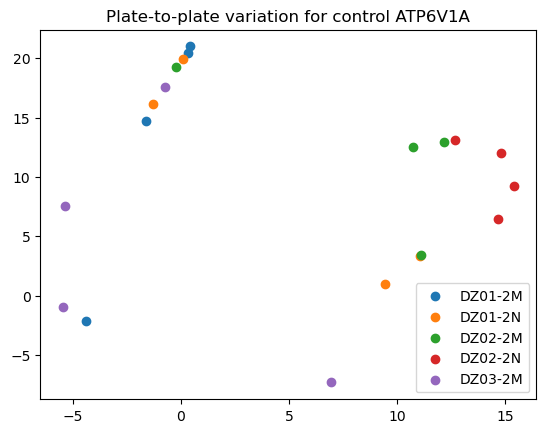

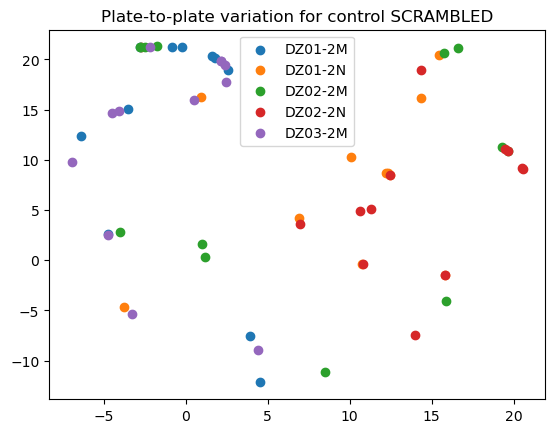

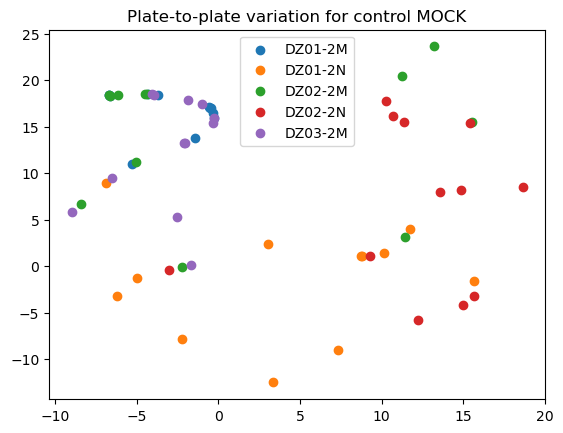

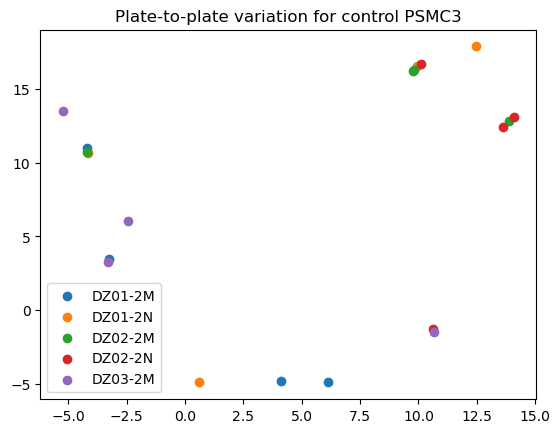

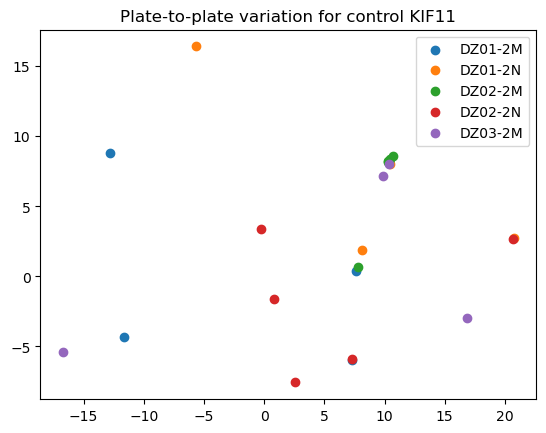

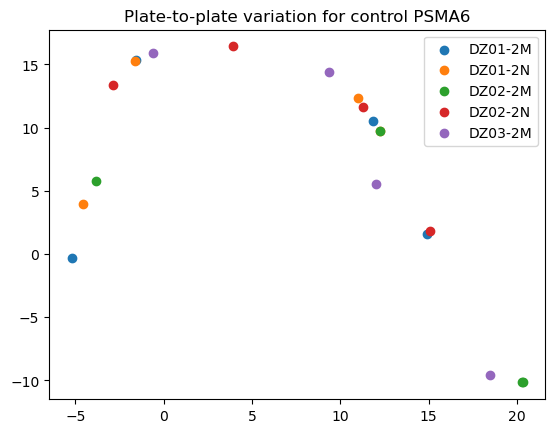

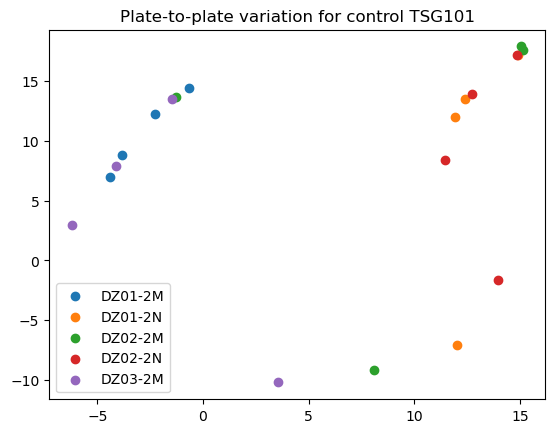

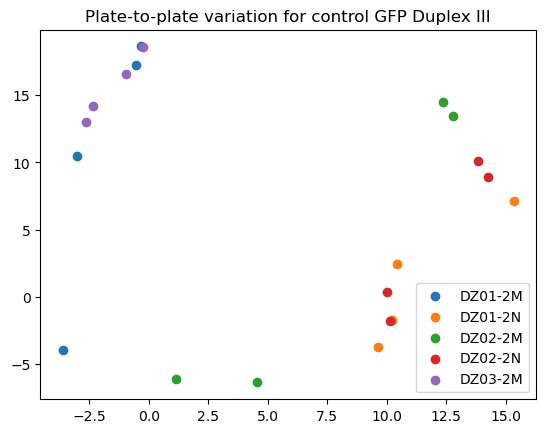

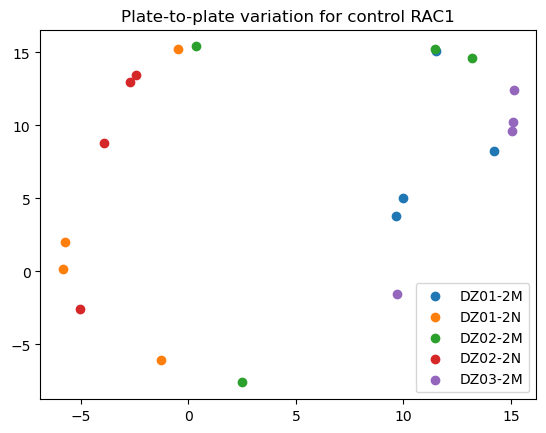

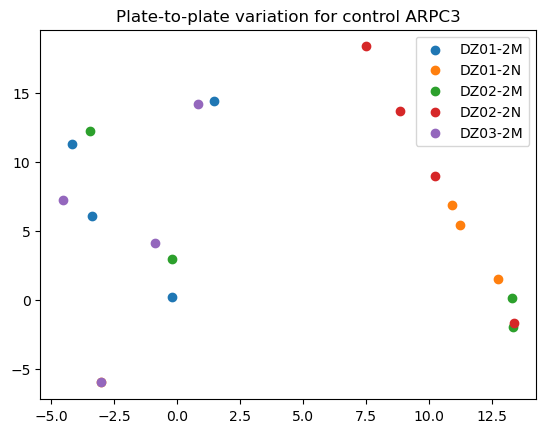

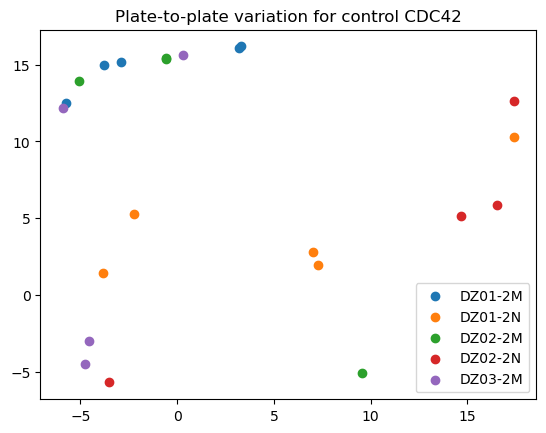

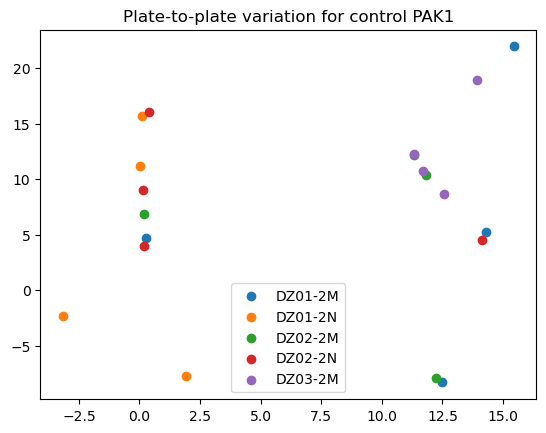

In [21]:
# For each control, plot the first 5 plates
N_PLATES = 5

colors = plt.get_cmap("tab10").colors

for control, reduced_embs, barcode_array in zip(
    control_names_dp_g1,
    reduced_embs_per_control,
    barcode_array_per_control
):
    fig, ax = plt.subplots(1, 1)

    # Extract the embeddings of the corresponding plate
    for barcode, color in zip(
        unique_plate_barcodes[:N_PLATES],
        colors[:N_PLATES]
    ):
        current_plate_embs = reduced_embs[
            barcode_array == barcode
        ]
        
        # Plot the embeddings of the current plate with a distinct color
        ax.scatter(
            current_plate_embs[:, 0],
            current_plate_embs[:, 1],
            color=color,
            label=barcode
        )
    ax.legend(loc="best")
    ax.set_title(
        f"Plate-to-plate variation for control {control}"
    )

    fig.savefig(
        os.path.join(
            images_raw_vals_embs_per_control_path,
            f"plate-to-plate_variation_control_{control}.png"
        ),
        dpi=400
    )

#### Pooled reduction

In [23]:
# Perform dimensionality reduction on all controls jointly
pooled_raw_subset = dp_screening_plates_df.loc[
    dp_screening_plates_df["Name"].isin(control_names_dp_g1),
    [
        "eCount_oCells",
        "dIntensity_cPathogen_eMean_oNuclei",
        "dIntensity_cPathogen_eMean_oPeriNuclei",
        "dIntensity_cPathogen_eMean_oCells",
        "dIntensity_cLatePathogen_eMean_oNuclei",
        "dIntensity_cLatePathogen_eMean_oPeriNuclei",
        "dIntensity_cLatePathogen_eMean_oCells"
    ]
]

pooled_reduced_embs = reducer.fit_transform(pooled_raw_subset)

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [28]:
pooled_barcode_array = dp_screening_plates_df.loc[
    dp_screening_plates_df["Name"].isin(control_names_dp_g1),
    "Barcode"
].to_numpy()
pooled_name_array = dp_screening_plates_df.loc[
    dp_screening_plates_df["Name"].isin(control_names_dp_g1),
    "Name"
].to_numpy()

In [29]:
images_raw_vals_pooled_embs_path = (
    "images_raw_vals_pooled_emb_reduction"
)

if not os.path.exists(images_raw_vals_pooled_embs_path):
    os.makedirs(images_raw_vals_pooled_embs_path)

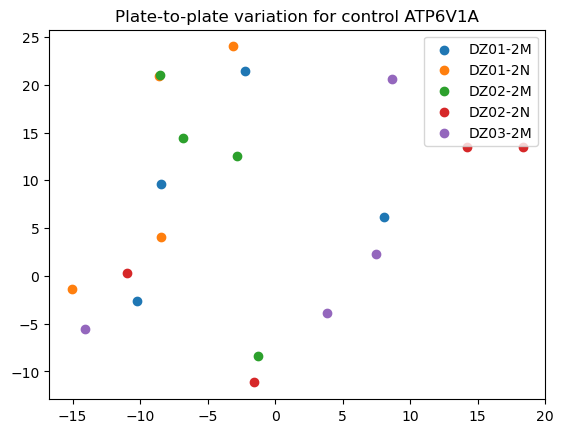

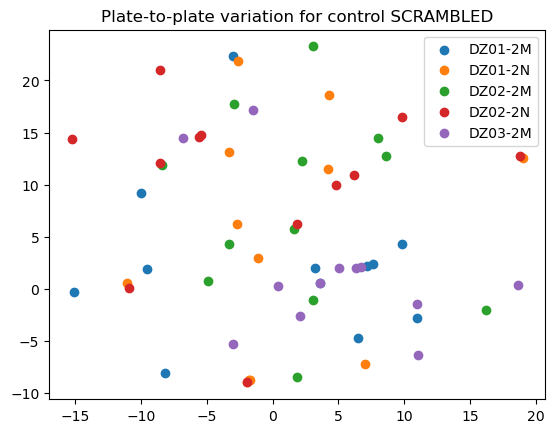

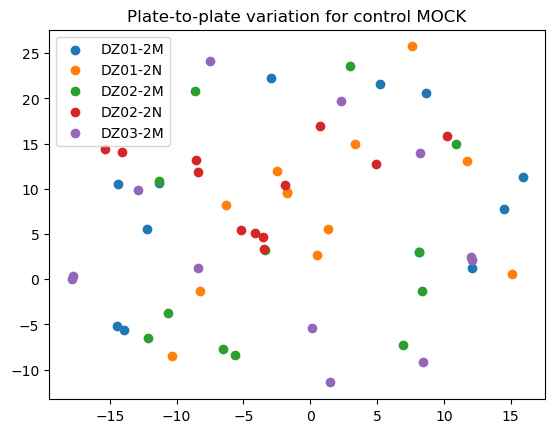

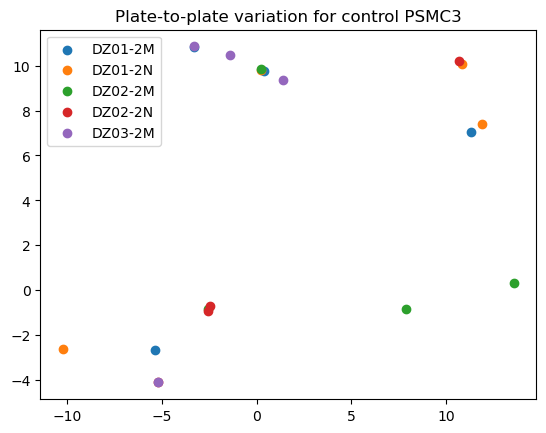

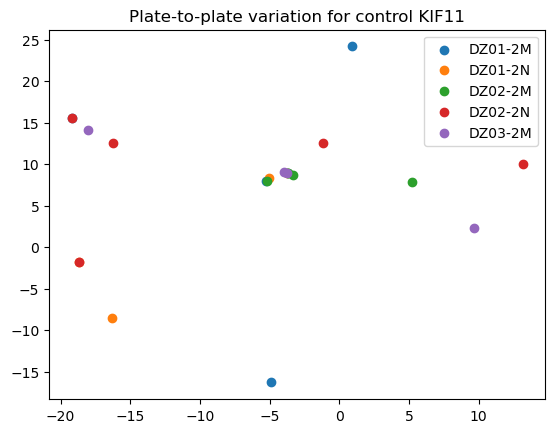

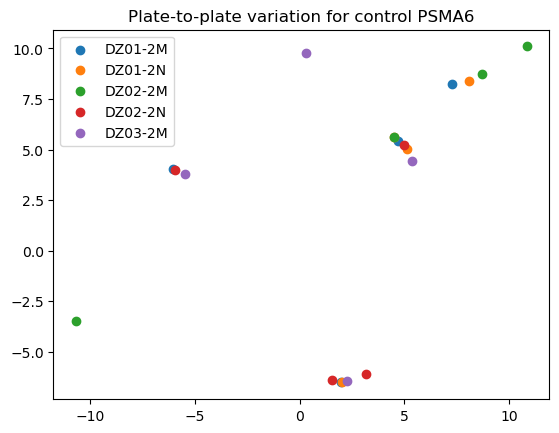

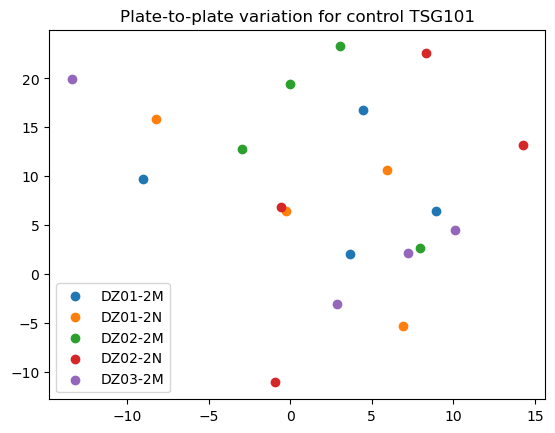

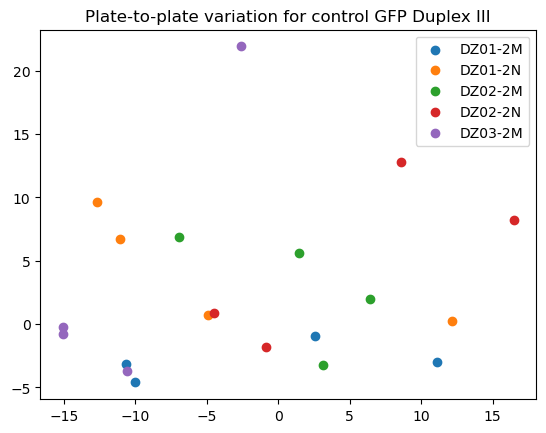

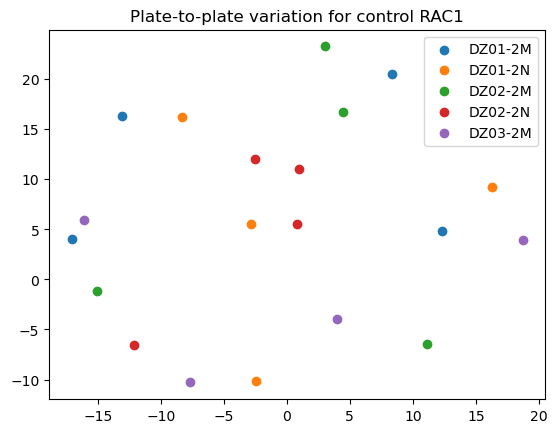

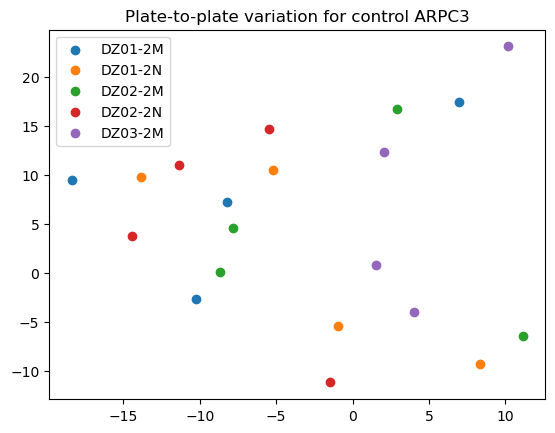

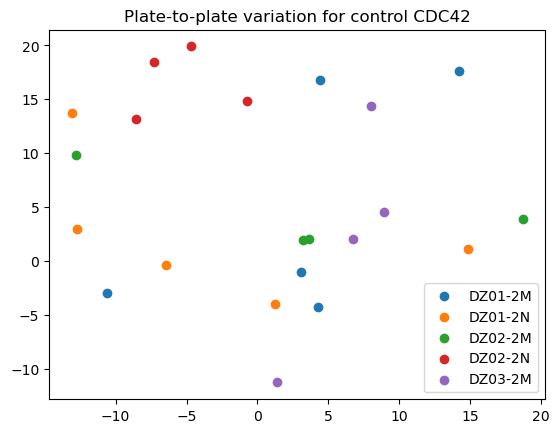

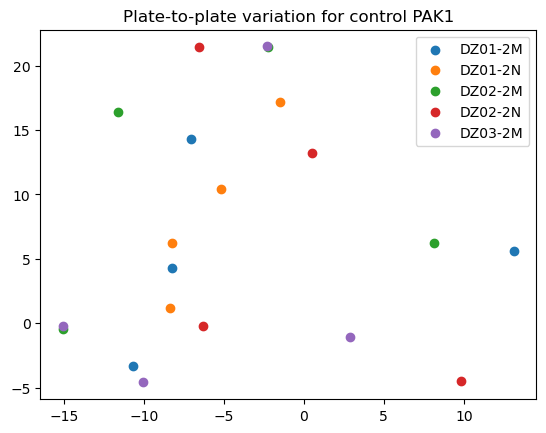

In [30]:
N_PLATES = 5

colors = plt.get_cmap("tab10").colors

for control in control_names_dp_g1:
    fig, ax = plt.subplots(1, 1)

    # Extract the embeddings of the corresponding plate
    for barcode, color in zip(
        unique_plate_barcodes[:N_PLATES],
        colors[:N_PLATES]
    ):
        current_control_and_plate_embs = pooled_reduced_embs[
            (pooled_name_array == control)
            &
            (pooled_barcode_array == barcode)
        ]
        
        ax.scatter(
            current_control_and_plate_embs[:, 0],
            current_control_and_plate_embs[:, 1],
            color=color,
            label=barcode
        )
        ax.legend(loc="best")
        ax.set_title(
            f"Plate-to-plate variation for control {control}"
        )

        fig.savefig(
            os.path.join(
                images_raw_vals_pooled_embs_path,
                f"plate-to-plate_variation_control_{control}.png"
            ),
            dpi=400
        )

### Dimensionality reduction of Z-scored values

#### Z-scoring

In [31]:
# Z-scoring consists of substracting the mean value and dividing the
# resulting difference by the standard deviation
# Note that Z-scoring is supposed to be done for each plate
# individually and also for each feature individually
raw_features_list = [
    "eCount_oCells",
    "dIntensity_cPathogen_eMean_oNuclei",
    "dIntensity_cPathogen_eMean_oPeriNuclei",
    "dIntensity_cPathogen_eMean_oCells",
    "dIntensity_cLatePathogen_eMean_oNuclei",
    "dIntensity_cLatePathogen_eMean_oPeriNuclei",
    "dIntensity_cLatePathogen_eMean_oCells"
]

# Note that in Z-scoring, all controls and interrogated genes are
# jointly standardized
for plate_barcode in unique_plate_barcodes:
    for raw_feature in raw_features_list:
        # Determine the mean as well as the standard deviation of the
        # current feature in the current plate
        current_mean = dp_screening_plates_df.loc[
            dp_screening_plates_df["Barcode"] == plate_barcode,
            raw_feature
        ].mean()
        current_std = dp_screening_plates_df.loc[
            dp_screening_plates_df["Barcode"] == plate_barcode,
            raw_feature
        ].std()

        # Perform the Z-scoring
        Z_scored_feature = raw_feature + "_nZScore"

        dp_screening_plates_df.loc[
            dp_screening_plates_df["Barcode"] == plate_barcode,
            Z_scored_feature
        ] = (dp_screening_plates_df.loc[
            dp_screening_plates_df["Barcode"] == plate_barcode,
            raw_feature
        ] - current_mean) / current_std

In [32]:
Z_scored_features_list = [
    raw_feature + "_nZScore"
    for raw_feature in raw_features_list
]

#### Per-control reduction

In [33]:
# Iterate over the list of control names, extract the corresponding
# subset from the DataFrame and perform dimensionality reduction
reduced_embs_per_control_Z_scored = []

for control in control_names_dp_g1:
    control_Z_scored_subset = dp_screening_plates_df.loc[
        dp_screening_plates_df["Name"] == control,
        Z_scored_features_list
    ]

    reduced_embs_per_control_Z_scored.append(
        reducer.fit_transform(control_Z_scored_subset)
    )

In [34]:
# Verify that the output has the expected shape
for control, reduced_embs in zip(
    control_names_dp_g1, reduced_embs_per_control_Z_scored
):
    sec_dim = reduced_embs.shape[1]
    assert sec_dim == 2, (
        f"The embeddings of control {control} have not been reduced to "
        "two dimensions!"
    )

In [35]:
images_Z_scored_vals_embs_per_control_path = (
    "images_Z_scored_vals_embs_reduction_per_control"
)

if not os.path.exists(images_Z_scored_vals_embs_per_control_path):
    os.makedirs(images_Z_scored_vals_embs_per_control_path)

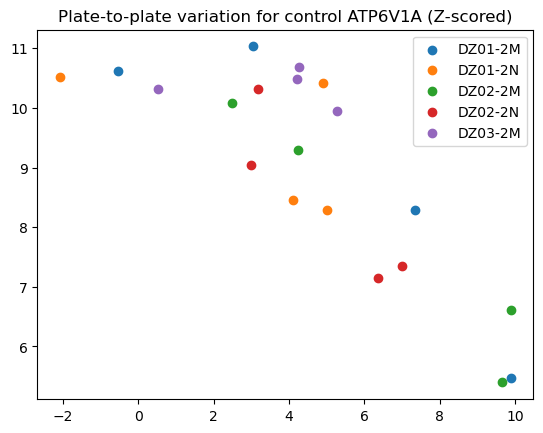

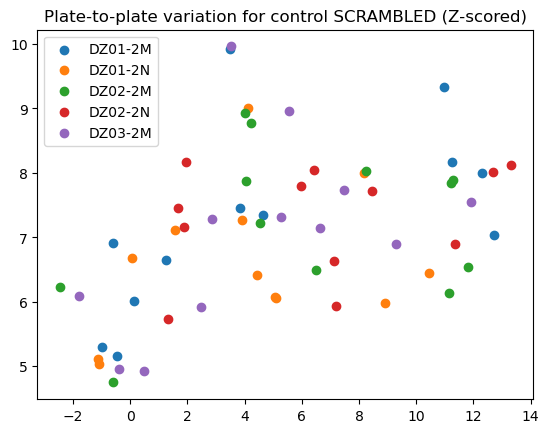

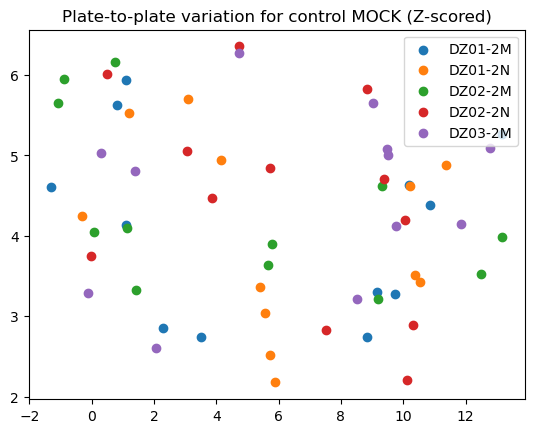

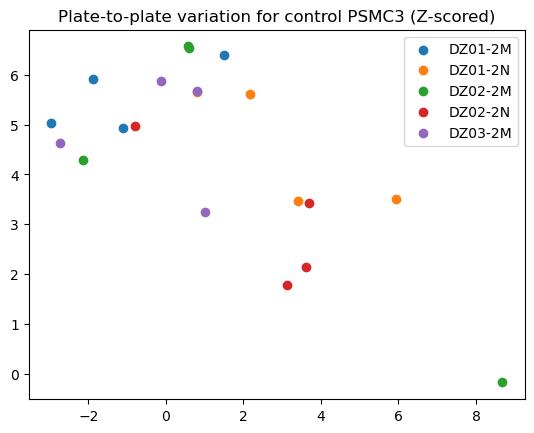

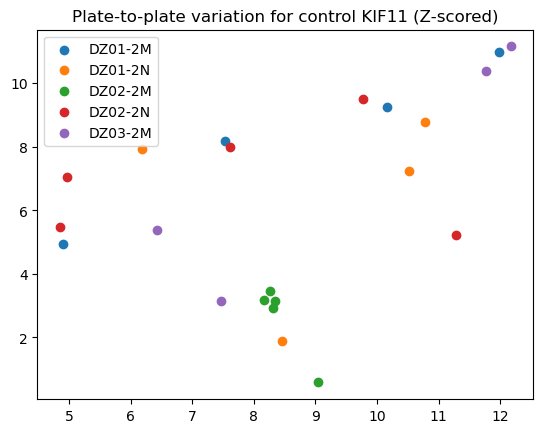

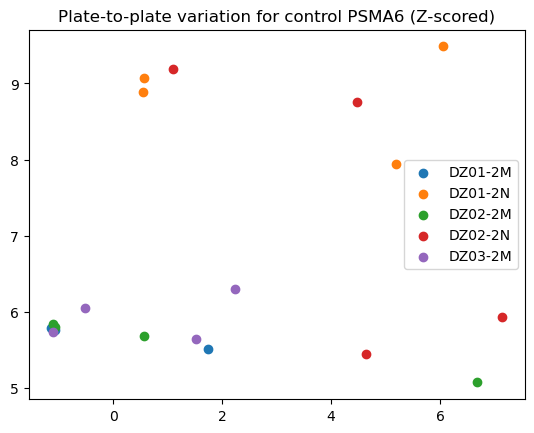

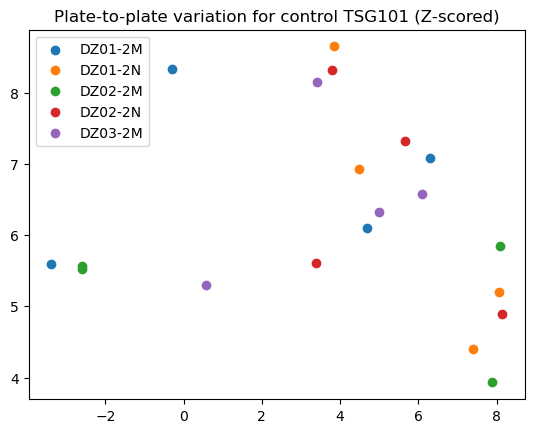

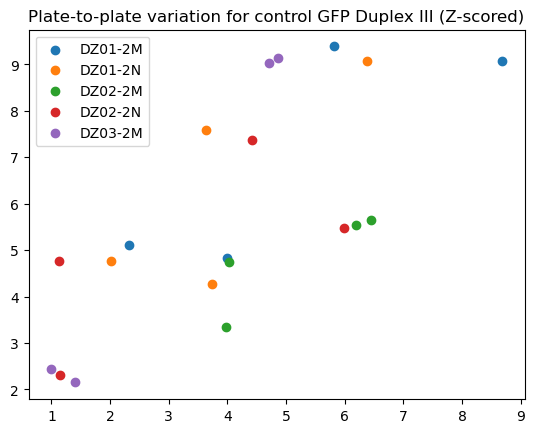

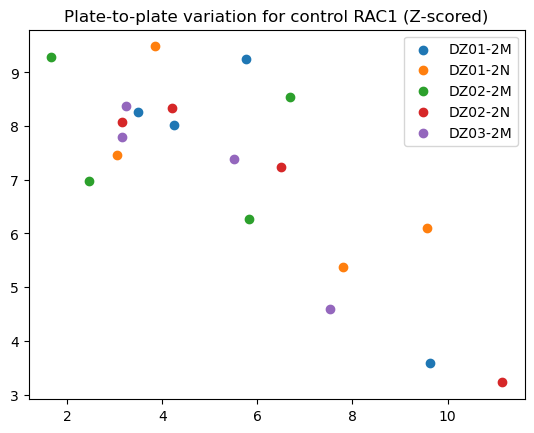

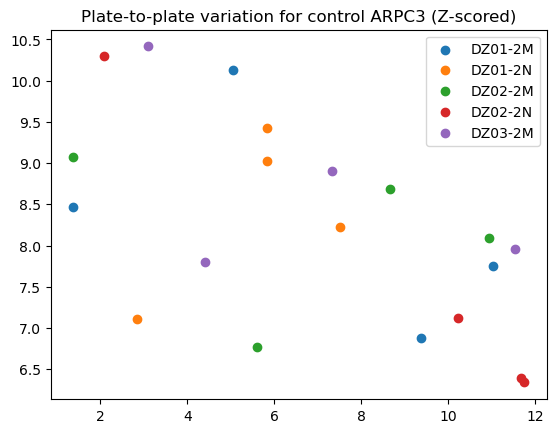

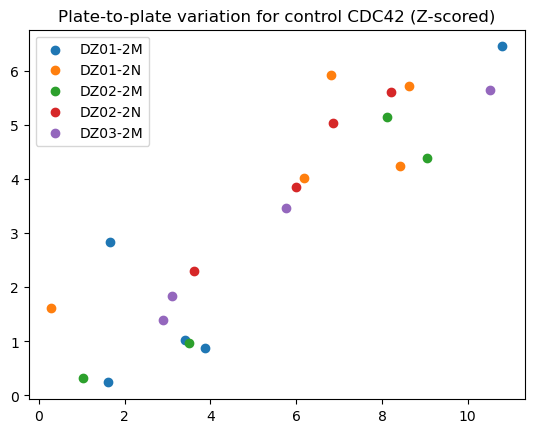

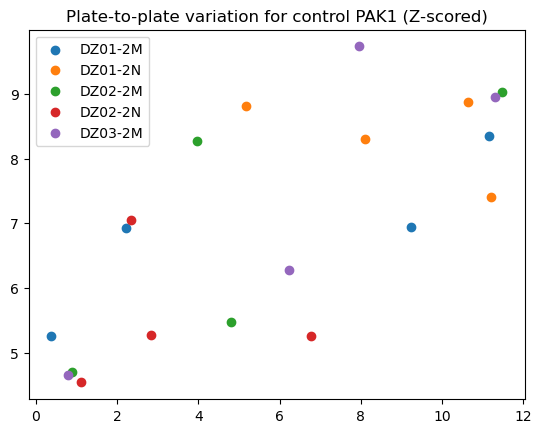

In [36]:
# For each control, plot the first 5 plates
N_PLATES = 5

colors = plt.get_cmap("tab10").colors

for control, reduced_embs, barcode_array in zip(
    control_names_dp_g1,
    reduced_embs_per_control_Z_scored,
    barcode_array_per_control
):
    fig, ax = plt.subplots(1, 1)

    # Extract the embeddings of the corresponding plate
    for barcode, color in zip(
        unique_plate_barcodes[:N_PLATES],
        colors[:N_PLATES]
    ):
        current_plate_embs = reduced_embs[
            barcode_array == barcode
        ]

        # Plot the embeddings of the current plate with a distinct color
        ax.scatter(
            current_plate_embs[:, 0],
            current_plate_embs[:, 1],
            color=color,
            label=barcode
        )
        ax.legend(loc="best")
        ax.set_title(
            f"Plate-to-plate variation for control {control} (Z-scored)"
        )

        fig.savefig(
            os.path.join(
                images_Z_scored_vals_embs_per_control_path,
                f"plate-to-plate_variation_control_{control}_Z_scored.png"
            ),
            dpi=400
        )

#### Pooled reduction

In [37]:
images_Z_scored_vals_pooled_embs_path = (
    "images_Z_scored_vals_pooled_emb_reduction"
)

if not os.path.exists(images_Z_scored_vals_pooled_embs_path):
    os.makedirs(images_Z_scored_vals_pooled_embs_path)

In [38]:
# Perform dimensionality reduction on all controls jointly
pooled_Z_scored_subset = dp_screening_plates_df.loc[
    dp_screening_plates_df["Name"].isin(control_names_dp_g1),
    Z_scored_features_list
]

pooled_Z_scored_reduced_embs = reducer.fit_transform(
    pooled_Z_scored_subset
)

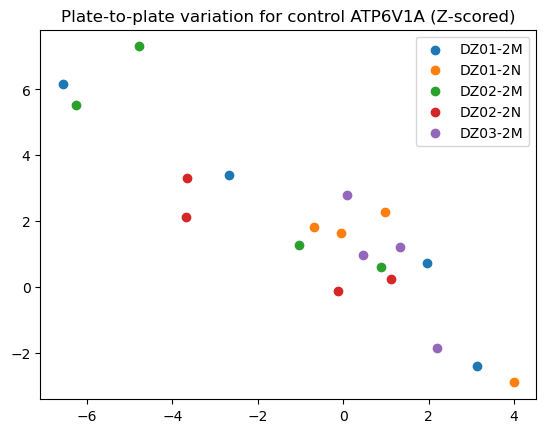

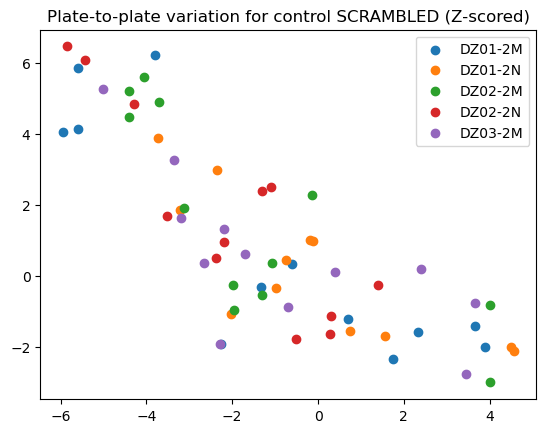

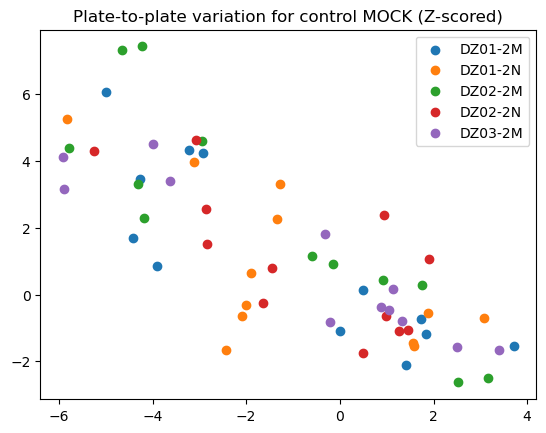

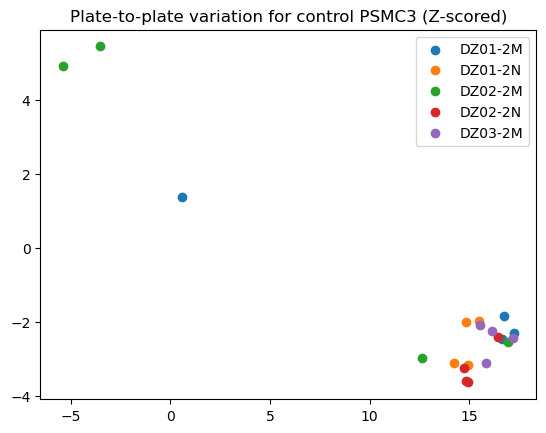

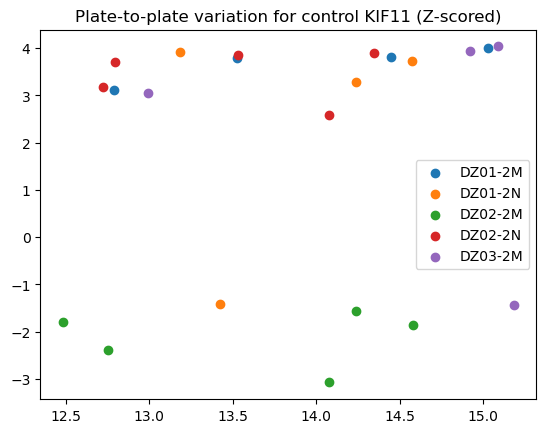

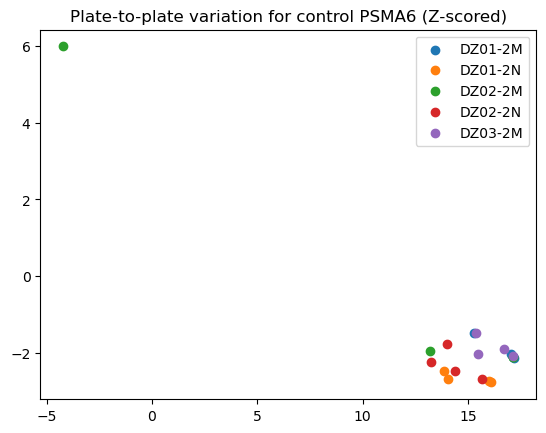

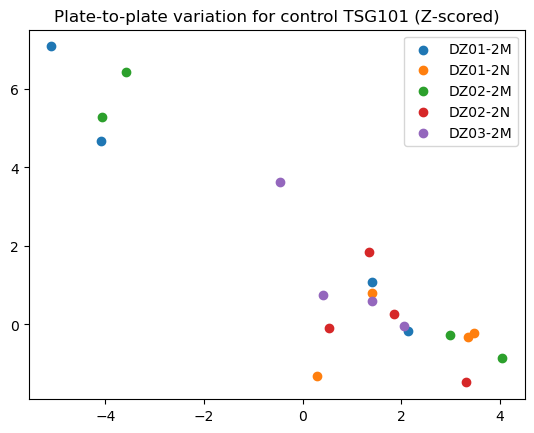

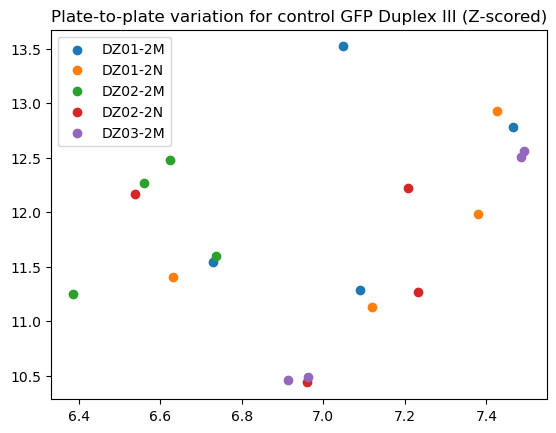

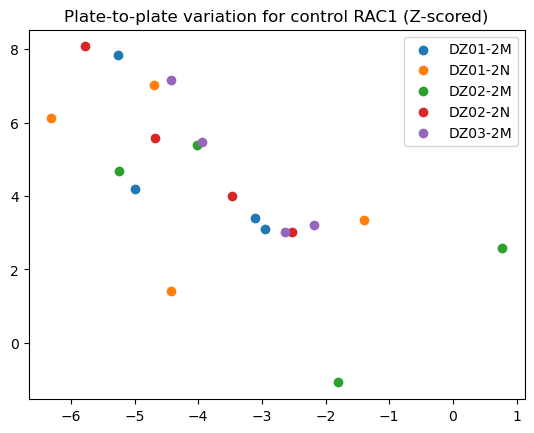

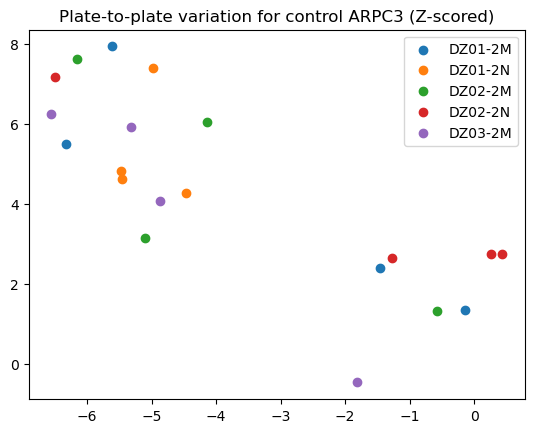

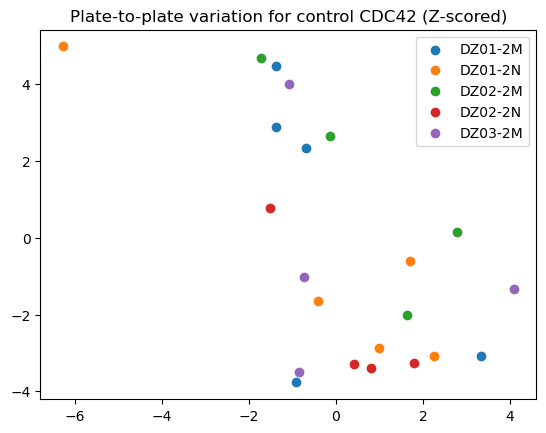

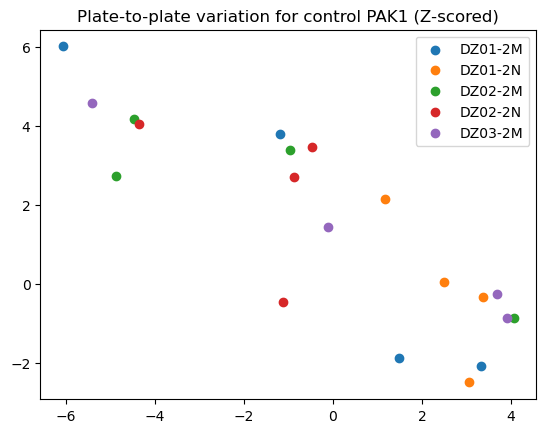

In [39]:
N_PLATES = 5

colors = plt.get_cmap("tab10").colors

for control in control_names_dp_g1:
    fig, ax = plt.subplots(1, 1)

    # Extract the embeddings of the corresponding plate
    for barcode, color in zip(
        unique_plate_barcodes[:N_PLATES],
        colors[:N_PLATES]
    ):
        current_control_and_plate_embs = pooled_Z_scored_reduced_embs[
            (pooled_name_array == control)
            &
            (pooled_barcode_array == barcode)
        ]

        ax.scatter(
            current_control_and_plate_embs[:, 0],
            current_control_and_plate_embs[:, 1],
            color=color,
            label=barcode
        )
        ax.legend(loc="best")
        ax.set_title(
            f"Plate-to-plate variation for control {control} (Z-scored)"
        )

        fig.savefig(
            os.path.join(
                images_Z_scored_vals_pooled_embs_path,
                f"plate-to-plate_variation_control_{control}_Z_scored.png"
            ),
            dpi=400
        )